In [1]:
!pip install pyspark

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DBSCAN")\
                            .config("spark.driver.memory", "12g")\
                            .config("spark.driver.maxResultSize", "2g")\
                            .getOrCreate()
print("PySpark Version:", spark.version)

PySpark Version: 3.5.3


In [2]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import functions as f

df = spark.read.csv("/content/data.csv", header=True, inferSchema=True)
df = df.select(["Read Speed","Write speed", "Digital Storage Capacity (GB)", "Memory Storage Capacity (GB)"]).dropna()
df = df.withColumn("index", monotonically_increasing_id())
df.show()

+-----------+-----------+-----------------------------+----------------------------+-----+
| Read Speed|Write speed|Digital Storage Capacity (GB)|Memory Storage Capacity (GB)|index|
+-----------+-----------+-----------------------------+----------------------------+-----+
|        0.0|        0.0|                          0.0|                 0.001736111|    0|
|0.001276596|        0.0|                          0.0|                     1.09E-4|    1|
|        0.0|        0.0|                       5.0E-4|                 0.020833333|    2|
| 0.00212766|        0.0|                          0.0|                 0.003472222|    3|
|        0.0|        0.0|                  0.003255208|                 0.138888889|    4|
|0.056737589|0.056737589|                      3.33E-4|                         0.0|    5|
|0.035460993|0.035460993|                      1.67E-4|                         0.0|    6|
|        0.0|        0.0|                        0.001|                         0.0|    7|

In [3]:
# Dùng cross join để tính khoảng cách một điểm đến cách điểm còn lại
df1 = df.alias("df1")
df2 = df.alias("df2")

distance_df = df1.crossJoin(df2) \
    .withColumn(
        "distance",
        f.sqrt(
            (f.col("df1.Read speed") - f.col("df2.Read speed"))**2 +
            (f.col("df1.Write speed") - f.col("df2.Write speed"))**2 +
            (f.col("df1.Digital Storage Capacity (GB)") - f.col("df2.Digital Storage Capacity (GB)"))**2 +
            (f.col("df1.Memory Storage Capacity (GB)") - f.col("df2.Memory Storage Capacity (GB)"))**2
        )
    )

distance_df.show()

+----------+-----------+-----------------------------+----------------------------+-----+-----------+-----------+-----------------------------+----------------------------+-----+--------------------+
|Read Speed|Write speed|Digital Storage Capacity (GB)|Memory Storage Capacity (GB)|index| Read Speed|Write speed|Digital Storage Capacity (GB)|Memory Storage Capacity (GB)|index|            distance|
+----------+-----------+-----------------------------+----------------------------+-----+-----------+-----------+-----------------------------+----------------------------+-----+--------------------+
|       0.0|        0.0|                          0.0|                 0.001736111|    0|        0.0|        0.0|                          0.0|                 0.001736111|    0|                 0.0|
|       0.0|        0.0|                          0.0|                 0.001736111|    0|0.001276596|        0.0|                          0.0|                     1.09E-4|    1|0.002068136251202275|


In [4]:
# Khai báo eps và minPts
eps = 0.2
minPts = 10
eps_broadcast = spark.sparkContext.broadcast(eps)
minPts_broadcast = spark.sparkContext.broadcast(minPts)

In [5]:
# Tính hàng xóm của mỗi điểm
neighbors_df = distance_df.groupBy("df1.index")\
                          .agg(f.collect_set(f.when(f.col("distance") <= eps_broadcast.value, f.col("df2.index")))\
                          .alias("neighbors"))
neighbors_df.show()

+-----+--------------------+
|index|           neighbors|
+-----+--------------------+
|    0|[0, 356, 843, 437...|
|    1|[0, 356, 843, 437...|
|    5|[0, 356, 843, 437...|
|    6|[0, 356, 843, 437...|
|    7|[0, 356, 843, 437...|
|    9|[0, 356, 843, 437...|
|   10|[0, 356, 843, 437...|
|   17|[0, 356, 843, 437...|
|   19|[0, 356, 843, 437...|
|   22|[0, 356, 843, 437...|
|   25|[0, 356, 843, 437...|
|   26|[0, 356, 843, 437...|
|   27|[0, 356, 843, 437...|
|   28|[0, 356, 843, 437...|
|   29|[0, 356, 843, 437...|
|   31|[0, 356, 843, 437...|
|   32|[0, 356, 843, 437...|
|   33|[0, 356, 843, 437...|
|   34|[0, 356, 843, 437...|
|   39|[0, 356, 843, 437...|
+-----+--------------------+
only showing top 20 rows



In [6]:
# Đánh dấu điểm core và khởi tạo cluster ban đầu là 0
neighbors_df = neighbors_df.withColumn("isCore", f.size(f.col("neighbors")) >= minPts_broadcast.value)\
                          .withColumn("cluster_id", f.lit(0))
neighbors_df.show()

+-----+--------------------+------+----------+
|index|           neighbors|isCore|cluster_id|
+-----+--------------------+------+----------+
|    0|[0, 356, 843, 437...|  true|         0|
|    1|[0, 356, 843, 437...|  true|         0|
|    5|[0, 356, 843, 437...|  true|         0|
|    6|[0, 356, 843, 437...|  true|         0|
|    7|[0, 356, 843, 437...|  true|         0|
|    9|[0, 356, 843, 437...|  true|         0|
|   10|[0, 356, 843, 437...|  true|         0|
|   17|[0, 356, 843, 437...|  true|         0|
|   19|[0, 356, 843, 437...|  true|         0|
|   22|[0, 356, 843, 437...|  true|         0|
|   25|[0, 356, 843, 437...|  true|         0|
|   26|[0, 356, 843, 437...|  true|         0|
|   27|[0, 356, 843, 437...|  true|         0|
|   28|[0, 356, 843, 437...|  true|         0|
|   29|[0, 356, 843, 437...|  true|         0|
|   31|[0, 356, 843, 437...|  true|         0|
|   32|[0, 356, 843, 437...|  true|         0|
|   33|[0, 356, 843, 437...|  true|         0|
|   34|[0, 35

In [7]:
# Tìm các điểm non_core_points
non_core_points = neighbors_df.filter(f.col("isCore") == False).select("index").withColumnRenamed("index", "non_core_index")
non_core_points.show()

+--------------+
|non_core_index|
+--------------+
|          1121|
|          1642|
|          1785|
|          1790|
|          1382|
+--------------+



In [8]:
# TÌm các điểm core_points
core_points = neighbors_df.filter(f.col("isCore") == True).select("index", "neighbors").withColumnRenamed("index", "core_index")
result_df = core_points.count()
result_df

1823

In [9]:
# Tìm các điểm border_points bằng cách inner join non_core_points và core_points với điều kiện non_core_poinst xuất hiện trong neigbors
# của core_points
border_points = non_core_points.join(
    core_points,
    f.array_contains(f.col("neighbors"), f.col("non_core_index")),  # Điều kiện neighbors chứa non-core point
    "inner"  # Giữ lại các non-core points thỏa mãn điều kiện
).select(f.col("non_core_index").alias("index"))  # Chỉ cần cột index

# Đánh dấu isBorder = True cho các border points
border_points = border_points.withColumn("isBorder", f.lit(True))
border_points.show()

+-----+--------+
|index|isBorder|
+-----+--------+
+-----+--------+



In [10]:
# Thực hiện neighbors left join border_poinst để thêm  cột các điểm border vừa tính ở trên
neighbors_df = neighbors_df.join(
    border_points,
    "index",
    "left"  # Giữ lại tất cả các điểm trong neighbors_df
).withColumn(
    "isBorder",
    f.when(f.col("isBorder").isNull(), False).otherwise(f.col("isBorder"))  # Mặc định False nếu không phải border
)
neighbors_df.show()

+-----+--------------------+------+----------+--------+
|index|           neighbors|isCore|cluster_id|isBorder|
+-----+--------------------+------+----------+--------+
|    0|[0, 356, 843, 437...|  true|         0|   false|
|    1|[0, 356, 843, 437...|  true|         0|   false|
|    5|[0, 356, 843, 437...|  true|         0|   false|
|    6|[0, 356, 843, 437...|  true|         0|   false|
|    7|[0, 356, 843, 437...|  true|         0|   false|
|    9|[0, 356, 843, 437...|  true|         0|   false|
|   10|[0, 356, 843, 437...|  true|         0|   false|
|   17|[0, 356, 843, 437...|  true|         0|   false|
|   19|[0, 356, 843, 437...|  true|         0|   false|
|   22|[0, 356, 843, 437...|  true|         0|   false|
|   25|[0, 356, 843, 437...|  true|         0|   false|
|   26|[0, 356, 843, 437...|  true|         0|   false|
|   27|[0, 356, 843, 437...|  true|         0|   false|
|   28|[0, 356, 843, 437...|  true|         0|   false|
|   29|[0, 356, 843, 437...|  true|         0|  

In [11]:
# Khai báo hàm xác định rdd có rỗng không
def is_empty(df):
    return df.rdd.isEmpty()

In [12]:
def expand_cluster(df, cluster_id):
    while True:
        # Lấy các điểm thuộc cụm hiện tại
        cluster_points = df.filter(f.col("cluster_id") == cluster_id)

        # Lấy danh sách hàng xóm của các điểm trong cụm
        neighbors = cluster_points.select(f.explode(f.col("neighbors")).alias("neighbor_index")).distinct()

        # Lọc các điểm mới, chỉ giữ lại các điểm mới bằng left anti join
        new_points = df.join(neighbors, f.col("index") == f.col("neighbor_index"), "left_anti") \
            .filter(f.col("cluster_id") == 0) \
            .select("index", "isCore", "isBorder").distinct()

        # Tách các điểm lõi và biên
        core_points = new_points.filter(f.col("isCore") == True)
        border_points = new_points.filter(f.col("isBorder") == True)

        # Kiểm tra nếu không có điểm mới
        if is_empty(core_points) and is_empty(border_points):
            break

        # Gán cluster_id cho cả core points và border points
        df = df.join(core_points.select("index").withColumnRenamed("index", "core_index"),
                     f.col("index") == f.col("core_index"), "left") \
            .join(border_points.select("index").withColumnRenamed("index", "border_index"),
                  f.col("index") == f.col("border_index"), "left") \
            .withColumn("cluster_id",
                        f.when(f.col("core_index").isNotNull(), cluster_id)
                         .when(f.col("border_index").isNotNull(), cluster_id)
                         .otherwise(f.col("cluster_id"))) \
            .drop("core_index", "border_index")
        # Đảm bảo lưu trữ ở executor cluster, tránh tính lại nhiều lần
        df = df.cache()
    return df


In [13]:
cluster_id = 0

while not neighbors_df.filter((f.col("isCore")) & (f.col("cluster_id") == 0)).isEmpty():
    # Lấy điểm core đầu tiên chưa thuộc cụm nào
    core_point = neighbors_df.filter((f.col("isCore")) & (f.col("cluster_id") == 0)).limit(1)

    neighbors = core_point.select(f.explode(f.col("neighbors")).alias("neighbor_index")).distinct()

    # Gán cluster_id cho điểm core này, sử dụng neighbors_df left join neighbors để cập nhật cluseter_id
    cluster_id += 1
    neighbors_df = neighbors_df.alias("df1").join(
        neighbors.alias("neighbors"),
        f.col("df1.index") == f.col("neighbors.neighbor_index"),
        "left"
    ).withColumn(
        "cluster_id",
        f.when(f.col("neighbors.neighbor_index").isNotNull(), cluster_id).otherwise(f.col("df1.cluster_id"))
    ).drop("neighbor_index")

    # Mở rộng cụm bằng cách gọi expand_cluster
    neighbors_df = expand_cluster(neighbors_df, cluster_id)


In [14]:
# Xem kết quả cuối cùng
neighbors_df.groupBy("cluster_id").count().show()

+----------+-----+
|cluster_id|count|
+----------+-----+
|         1| 1787|
|         2|   36|
|         0|    5|
+----------+-----+



Tính Silhoutte 

In [15]:
neighbors_df.show(10)

+-----+--------------------+------+----------+--------+
|index|           neighbors|isCore|cluster_id|isBorder|
+-----+--------------------+------+----------+--------+
|   26|[0, 356, 843, 437...|  true|         1|   false|
|   29|[0, 356, 843, 437...|  true|         1|   false|
|  474|[0, 356, 843, 437...|  true|         1|   false|
|  964|[0, 356, 843, 437...|  true|         1|   false|
| 1677|[0, 356, 843, 437...|  true|         1|   false|
| 1697|[0, 356, 843, 437...|  true|         1|   false|
| 1806|[0, 356, 843, 437...|  true|         1|   false|
|   65|[0, 356, 843, 437...|  true|         1|   false|
|  191|[0, 356, 843, 437...|  true|         1|   false|
|  418|[0, 356, 843, 437...|  true|         1|   false|
+-----+--------------------+------+----------+--------+
only showing top 10 rows



In [16]:
# Loại bỏ khoảng cách đến chính điểm đó
total_distance_df = distance_df.select(["df1.index", "df2.index", "distance"]).filter(f.col("df1.index") != f.col("df2.index"))
total_distance_df = total_distance_df.toDF("index1","index2","distance")
# Lấy các cluster_id của index1
test_df = total_distance_df.join(neighbors_df, f.col("index1") == f.col("index"), "left").drop("neighbors","isCore","isBorder","index").filter(f.col("cluster_id") != 0)
# Lấy các cluster_id của index2
test_df = test_df.join(neighbors_df, f.col("index2") == f.col("index"), "left").drop("neighbors","isCore","isBorder","index")
test_df = test_df.toDF("index1","index2","distance", "cluster_id1","cluster_id2")
test_df.show(10, truncate=False)

+------+------+---------------------+-----------+-----------+
|index1|index2|distance             |cluster_id1|cluster_id2|
+------+------+---------------------+-----------+-----------+
|26    |0     |0.001643427837272145 |1          |1          |
|65    |0     |8.681110000000001E-4 |1          |1          |
|222   |0     |0.002648411109386343 |1          |1          |
|243   |0     |0.0019112436281963113|1          |1          |
|19    |0     |0.0017380182289955994|1          |1          |
|502   |0     |0.0021890313595766507|1          |1          |
|112   |0     |0.006157188696137466 |1          |1          |
|237   |0     |0.0018598307461489608|1          |1          |
|22    |0     |0.008070731013265341 |1          |1          |
|130   |0     |0.012157339434155978 |1          |1          |
+------+------+---------------------+-----------+-----------+
only showing top 10 rows



In [17]:
# Group_by để tính khoảng cách trung bình của 1 điểm trong cụm
ai_df = test_df.groupBy("index1", "cluster_id1").agg(f.avg("distance").alias("a_i"))
ai_df.show(10, truncate = False)

+------+-----------+--------------------+
|index1|cluster_id1|a_i                 |
+------+-----------+--------------------+
|1200  |1          |0.029501533993814565|
|212   |1          |0.03059192119557309 |
|138   |1          |0.04253444995376644 |
|177   |1          |0.03628905853523964 |
|467   |1          |0.15015835774502337 |
|1013  |1          |0.036983100222320174|
|1047  |1          |0.02952504003274591 |
|1486  |1          |0.03058940465399798 |
|1577  |1          |0.029602419410803795|
|1454  |1          |0.06828300027592771 |
+------+-----------+--------------------+
only showing top 10 rows



In [18]:
# Group_by để tính khoảng cách đến cách cụm khác
bi_df = test_df.filter(f.col("cluster_id1") != f.col("cluster_id2")).groupBy("index1", "cluster_id1", "cluster_id2").agg(f.avg("distance").alias("avg_b_i"))
# Group by để tính khoảng cách nhỏ nhất đến cụm khác
bi_df = bi_df.groupBy("index1", "cluster_id1").agg(f.min("avg_b_i").alias("b_i"))
bi_df.show(10, truncate = False)

+------+-----------+-------------------+
|index1|cluster_id1|b_i                |
+------+-----------+-------------------+
|1486  |1          |0.3426954399441209 |
|212   |1          |0.34269559496346275|
|1577  |1          |0.3428375764008859 |
|1013  |1          |0.3335608397564385 |
|1047  |1          |0.34289112346901757|
|1454  |1          |0.2900500902782739 |
|780   |1          |0.34286404935037473|
|1676  |1          |0.3340303845192066 |
|482   |1          |0.34286404935037473|
|467   |1          |0.36293920899747434|
+------+-----------+-------------------+
only showing top 10 rows



In [19]:
# a_i inner join b_i, chỉ giữ lại cột index1, a_i, b_i
silhouette_df = ai_df.join(bi_df, "index1").drop("cluster_id1")
# Tính silhoutte từng điểm
silhouette_df = silhouette_df.withColumn("silhouette", (f.col("b_i") - f.col("a_i")) / f.greatest(f.col("a_i"), f.col("b_i")))
silhouette_df = silhouette_df.drop("a_i", "b_i")
#silhouette_df.select("index1", "silhouette").show(10, truncate=False)

In [20]:
# Tính silhoutte trung bình
silhouette_df = silhouette_df.select("silhouette")
average_silhouette_df = silhouette_df.agg(f.avg("silhouette").alias("avg_silhouette"))
result = average_silhouette_df.take(1)
print(result)

[Row(avg_silhouette=0.8554276354987757)]


Restart Spark session để tính Heatmmap

In [22]:
def DBSCAN(df, eps, minPts):
  df1 = df.alias("df1")
  df2 = df.alias("df2")

  distance_df = df1.crossJoin(df2) \
    .withColumn(
        "distance",
        f.sqrt(
            (f.col("df1.Read speed") - f.col("df2.Read speed"))**2 +
            (f.col("df1.Write speed") - f.col("df2.Write speed"))**2 +
            (f.col("df1.Digital Storage Capacity (GB)") - f.col("df2.Digital Storage Capacity (GB)"))**2 +
            (f.col("df1.Memory Storage Capacity (GB)") - f.col("df2.Memory Storage Capacity (GB)"))**2
        )
    )

  eps_broadcast = spark.sparkContext.broadcast(eps)
  minPts_broadcast = spark.sparkContext.broadcast(minPts)

  neighbors_df = distance_df.groupBy("df1.index")\
                            .agg(f.collect_set(f.when(f.col("distance") <= eps_broadcast.value, f.col("df2.index")))\
                            .alias("neighbors"))
  neighbors_df = neighbors_df.withColumn("isCore", f.size(f.col("neighbors")) >= minPts_broadcast.value)\
                              .withColumn("cluster_id", f.lit(0))
  non_core_points = neighbors_df.filter(f.col("isCore") == False).select("index").withColumnRenamed("index", "non_core_index")
  core_points = neighbors_df.filter(f.col("isCore") == True).select("index", "neighbors").withColumnRenamed("index", "core_index")
  border_points = non_core_points.join(
    core_points,
    f.array_contains(f.col("neighbors"), f.col("non_core_index")),  # Điều kiện neighbors chứa non-core point
    "inner"  # Giữ lại các non-core points thỏa mãn điều kiện
  ).select(f.col("non_core_index").alias("index"))  # Chỉ cần cột index

  # Đánh dấu isBorder = True cho các border points
  border_points = border_points.withColumn("isBorder", f.lit(True))

  neighbors_df = neighbors_df.join(
    border_points,
    "index",
    "left"  # Giữ lại tất cả các điểm trong neighbors_df
  ).withColumn(
    "isBorder",
    f.when(f.col("isBorder").isNull(), False).otherwise(f.col("isBorder"))  # Mặc định False nếu không phải border
  )

  def is_empty(df):
    return df.rdd.isEmpty()

  def expand_cluster(df, cluster_id):
    while True:
        # Lấy các điểm thuộc cụm hiện tại
        cluster_points = df.filter(f.col("cluster_id") == cluster_id)

        # Lấy danh sách hàng xóm của các điểm trong cụm
        neighbors = cluster_points.select(f.explode(f.col("neighbors")).alias("neighbor_index")).distinct()

        # Phân loại điểm mới:
        new_points = df.join(neighbors, f.col("index") == f.col("neighbor_index"), "left_anti") \
            .filter(f.col("cluster_id") == 0) \
            .select("index", "isCore", "isBorder").distinct()

        # Tách các điểm lõi và biên
        core_points = new_points.filter(f.col("isCore") == True)
        border_points = new_points.filter(f.col("isBorder") == True)

        # Kiểm tra nếu không có điểm mới
        if is_empty(core_points) and is_empty(border_points):
            break

        # Gán cluster_id cho cả core points và border points
        df = df.join(core_points.select("index").withColumnRenamed("index", "core_index"),
                     f.col("index") == f.col("core_index"), "left") \
            .join(border_points.select("index").withColumnRenamed("index", "border_index"),
                  f.col("index") == f.col("border_index"), "left") \
            .withColumn("cluster_id",
                        f.when(f.col("core_index").isNotNull(), cluster_id)
                         .when(f.col("border_index").isNotNull(), cluster_id)
                         .otherwise(f.col("cluster_id"))) \
            .drop("core_index", "border_index")
        df = df.cache()
    return df

  cluster_id = 0

  while not neighbors_df.filter((f.col("isCore")) & (f.col("cluster_id") == 0)).isEmpty():
    # Lấy điểm core đầu tiên chưa thuộc cụm nào
    core_point = neighbors_df.filter((f.col("isCore")) & (f.col("cluster_id") == 0)).limit(1)

    neighbors = core_point.select(f.explode(f.col("neighbors")).alias("neighbor_index")).distinct()

    # Gán cluster_id cho điểm core này
    cluster_id += 1
    neighbors_df = neighbors_df.alias("df1").join(
        neighbors.alias("neighbors"),
        f.col("df1.index") == f.col("neighbors.neighbor_index"),
        "left"
    ).withColumn(
        "cluster_id",
        f.when(f.col("neighbors.neighbor_index").isNotNull(), cluster_id).otherwise(f.col("df1.cluster_id"))
    ).drop("neighbor_index")

    # Mở rộng cụm bằng cách gọi expand_cluster
    neighbors_df = expand_cluster(neighbors_df, cluster_id)
  return neighbors_df.groupBy("cluster_id").count()

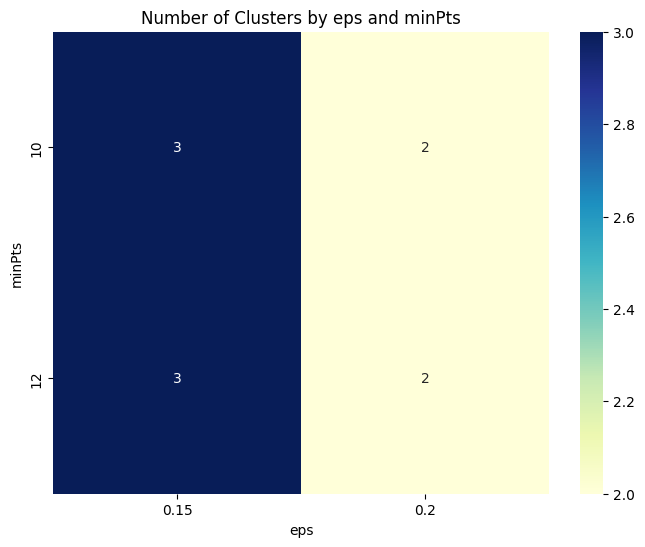

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sử dụng giá trị eps cụ thể
eps_values = [0.15, 0.2]
minPts_values = [10, 12]
results = []

# Thực hiện vòng lặp để tính số cụm
for eps in eps_values:
    row = []  # Một hàng trong ma trận heatmap
    for minPts in minPts_values:
        # Gọi hàm DBSCAN để nhận DataFrame
        cluster_df = DBSCAN(df, eps, minPts)

        # Tính số lượng cụm (lọc cụm nhiễu nếu có)
        num_clusters = cluster_df.filter(cluster_df["cluster_id"] != 0).count()

        # Ghi lại kết quả cho hàng hiện tại
        row.append(num_clusters)
    results.append(row)

# Vẽ heatmap từ ma trận kết quả
plt.figure(figsize=(8, 6))
sns.heatmap(
    np.array(results).T,  # Chuyển kết quả thành numpy array và transpose
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar=True,
    xticklabels=eps_values,  # Sử dụng trực tiếp danh sách eps_values làm nhãn
    yticklabels=minPts_values,
)
plt.title("Number of Clusters by eps and minPts")
plt.xlabel("eps")
plt.ylabel("minPts")
plt.show()
